In [29]:
import sys
from time import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold, datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from matplotlib import patches as mpatches
%matplotlib inline 

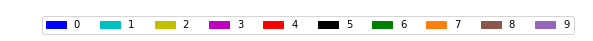

In [2]:
colors = ['b', 'c', 'y', 'm', 'r', 'k', 'g', 'C1', 'C5', 'C4']
patches = [mpatches.Patch(color=c, label=i) for i, c in enumerate(colors)]
plt.figure(figsize=(10,0.05))
plt.legend(handles=patches, ncol=10)

plt.axis('off')
plt.show()

In [3]:
data_home = '/home/lucio/Documents/PhD/Courses/SLT/mnist/'
mnist = datasets.fetch_mldata('MNIST original', data_home=data_home)

In [4]:
def plot_embedding(X, y, title=None):
    d = X.shape[1]
    
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    #plt.figure()
    col = ['b', 'c', 'y', 'm', 'r', 'k', 'g', 'C1', 'C5', 'C4']
    colors = list(map(lambda x:col[int(x)], y))
    
    fig = plt.figure(figsize=(15,10))
    if d==3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[:,0], X[:,1], X[:,2], c=colors)
        
    if d==2:
        ax = fig.add_subplot(111)
        plt.scatter(X[:,0], X[:,1], c=colors)
    
    
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title, fontsize=24)

In [5]:
def calc_and_plot(X, n, out_d):
    nb_samples = X.shape[0]
    clf = manifold.LocallyLinearEmbedding(n_neighbors=n, n_components=out_d,
                                      method='standard', n_jobs=4)
    t0 = time()
    X_lle = clf.fit_transform(X)
    title = "{} samples - {} neighbours - time: {:.2f}s)".format(
            nb_samples, n, (time() - t0))
    plot_embedding(X_lle, y, title)

In [248]:
nb_samples = 500
samples = np.random.choice(mnist.data.shape[0], nb_samples)
X = mnist.data[samples, :]
n_samples, n_features = X.shape
y = mnist.target[samples]

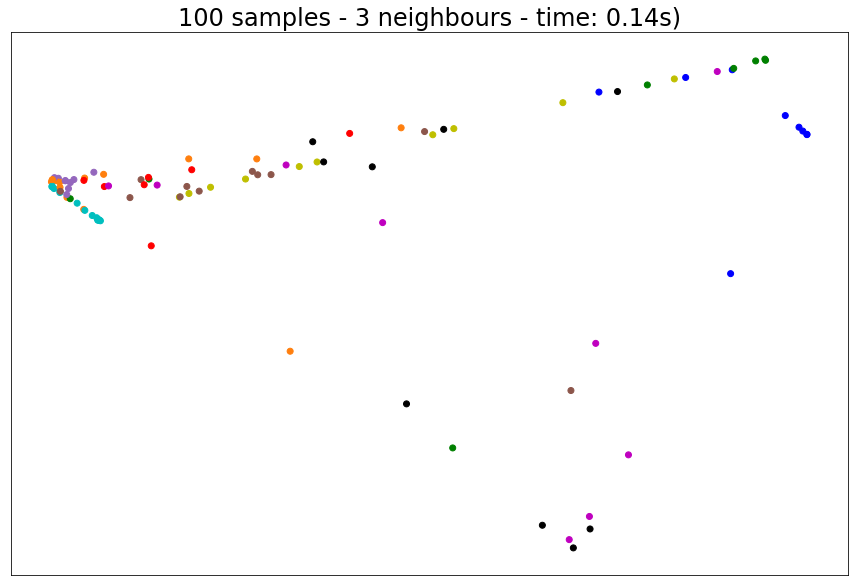

In [7]:
calc_and_plot(X, n=3, out_d=2)

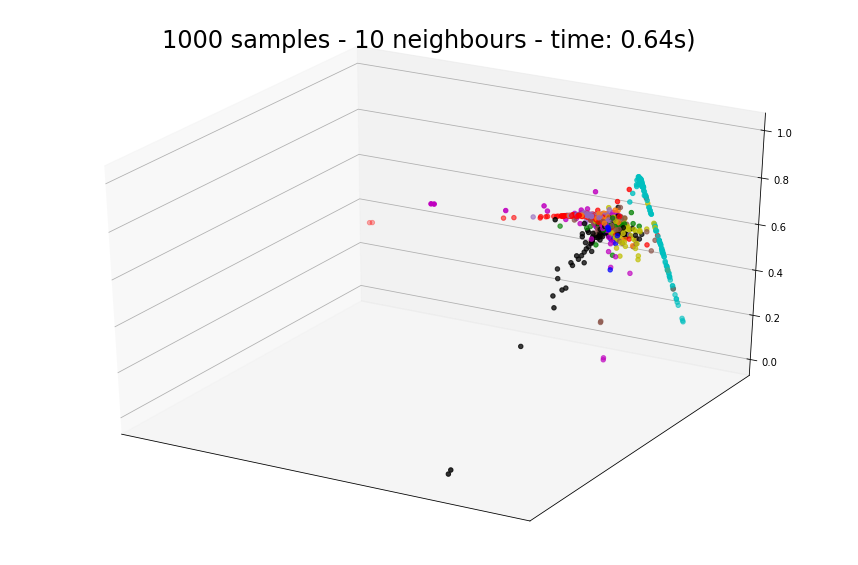

In [81]:
calc_and_plot(X, n=10, out_d=3)

## Sklearn code

In [131]:
def barycenter_kneighbors_graph(X, n_neighbors, reg=1e-3, n_jobs=1, metric='x'):
    #print('X in graph', X.shape, X.sum())
    knn = NearestNeighbors(n_neighbors + 1, n_jobs=n_jobs, metric=metric).fit(X)
    #X = knn._fit_X
    n_samples = X.shape[0]
    ind = knn.kneighbors(X, return_distance=False)[:, 1:]
    data = barycenter_weights(X, X[ind], reg=reg)
    indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)
    #return scipy.sparse.csr_matrix((data.ravel(), ind.ravel(), indptr),
    #                  shape=(n_samples, n_samples)).toarray()
    return fill_W(data, ind, n_samples)

def fill_W(data, ind, n_samples):
    W=np.zeros((n_samples,n_samples))
    for i, w in enumerate(data):
        if len(w)!=10:
            print(len(w))
        W[i,ind[i]] = w
    return W
        

def barycenter_weights(X, Z, reg=1e-3):

    n_samples, n_neighbors = X.shape[0], Z.shape[1]
    B = np.empty((n_samples, n_neighbors), dtype=X.dtype)
    v = np.ones(n_neighbors, dtype=X.dtype)

    for i, A in enumerate(Z.transpose(0, 2, 1)):
        #print('A', A.shape, A.sum())
        
        C = A.T - X[i]  # broadcasting
        G = np.dot(C, C.T)
        trace = np.trace(G)
        if trace > 0:
            R = reg * trace*1.0
        else:
            R = reg*1.0
        #print(G)
        G.flat[::Z.shape[1] + 1] += R
        w = scipy.linalg.solve(G, v, sym_pos=True)
        B[i, :] = w / np.sum(w)
    return B

def null_space(M, k, k_skip=1, eigen_solver='dense', tol=1E-6, max_iter=100,
               random_state=None):
        eigen_values, eigen_vectors = scipy.linalg.eigh(
            M, eigvals=(k_skip, k + k_skip - 1), overwrite_a=True)
        index = np.argsort(np.abs(eigen_values))
        return eigen_vectors[:, index]#, np.sum(eigen_values)

def locally_linear_embedding(
        X, n_neighbors, n_components, reg=1e-3, eigen_solver='dense', tol=1e-6,
        max_iter=100, method='standard', hessian_tol=1E-4, modified_tol=1E-12,
        random_state=None, n_jobs=1, metric='minkowski'):
    
#    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, n_jobs=n_jobs)
#    nbrs.fit(X)
#    X = nbrs._fit_X

    N, d_in = X.shape

    if method == 'standard':
        W = barycenter_kneighbors_graph(
#            nbrs, n_neighbors=n_neighbors, reg=reg, n_jobs=n_jobs)
             X, n_neighbors=n_neighbors, reg=reg, n_jobs=n_jobs, metric=metric)

        # we'll compute M = (I-W)'(I-W)
        # depending on the solver, we'll do this differently
        
        #M = (W.T @ W - W.T - W)
        #M.flat[::M.shape[0] + 1] += 1  # W = W - I = W - I
        M=(np.eye(*W.shape)-W)
        M = (M.T @ M)

    return null_space(M, n_components, k_skip=1, eigen_solver=eigen_solver,
                      tol=tol, max_iter=max_iter, random_state=random_state), M, W

def sk_lle(X, nb_neighb, out_d, metric='minkowski'):
        #nbrs_ = NearestNeighbors(nb_neighb, metric=metric)
        #nbrs_.fit(X)
        X = X.astype('float')
        #print('X in main', X.shape, X.sum())
        return  locally_linear_embedding(X, nb_neighb, out_d, metric=metric)

In [134]:
nb_neighb_1=10
Y, M_skW, W_skW = sk_lle(X, nb_neighb_1 , out_d=3)

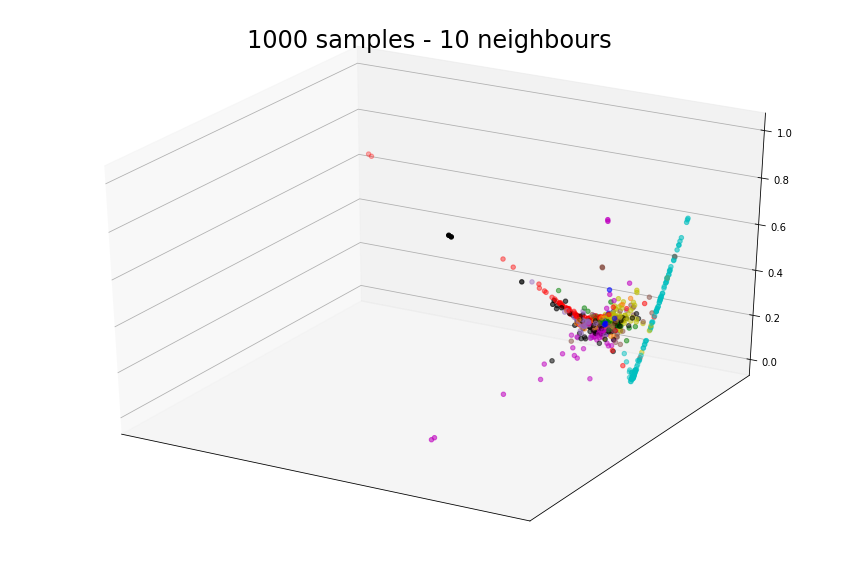

In [85]:
plot_embedding(Y, y, "{} samples - {} neighbours".format(
            X.shape[0], nb_neighb_1))

## M matrix plot

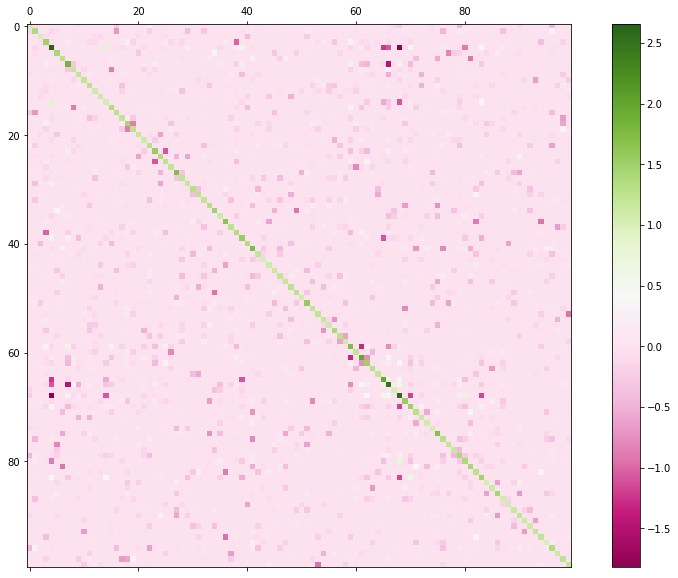

In [45]:
plt.figure(figsize=(15,10))
plt.matshow(np.clip(M_skW,-100, 100),cmap='PiYG', fignum=0)
plt.colorbar()

In [49]:
print('non zero', np.count_nonzero(M_skW))
print('total', M_skW.shape )


non zero 3934
total (100, 100)


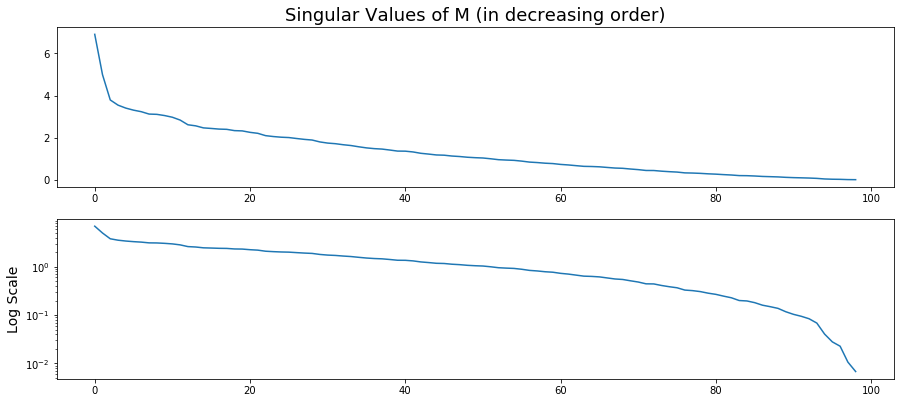

In [51]:
u,s,v = np.linalg.svd(M_skW)

plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
plt.title('Singular Values of M (in decreasing order)', fontsize=18)
plt.plot(s[:-1])
plt.subplot(3, 1, 2)
plt.ylabel('Log Scale', fontsize=14)
plt.semilogy(s[:-1], basey=10)


In [ ]:
s

## Clusters in the data

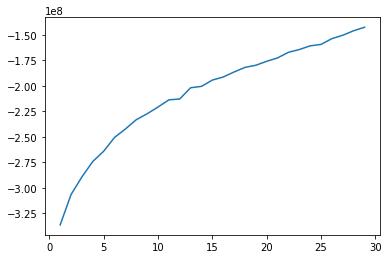

In [25]:
Ks = range(1, 30)
km = [KMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(X).score(X) for i in range(len(km))]
plt.plot(Ks, score)

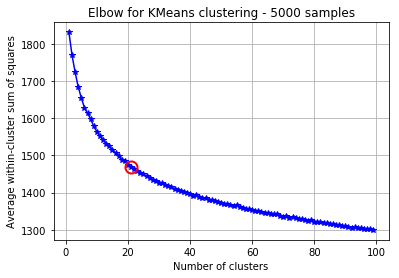

In [42]:
from scipy.spatial.distance import cdist
K = range(1,100)

# scipy.cluster.vq.kmeans
KM = [KMeans(k).fit(X) for k in K]

centroids = [km.cluster_centers_ for km in KM]   # cluster centroids
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

##### plot ###
kIdx = 20

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering - 5000 samples')


## Using a different metric

In [61]:
M_skW.shape

(1000, 1000)

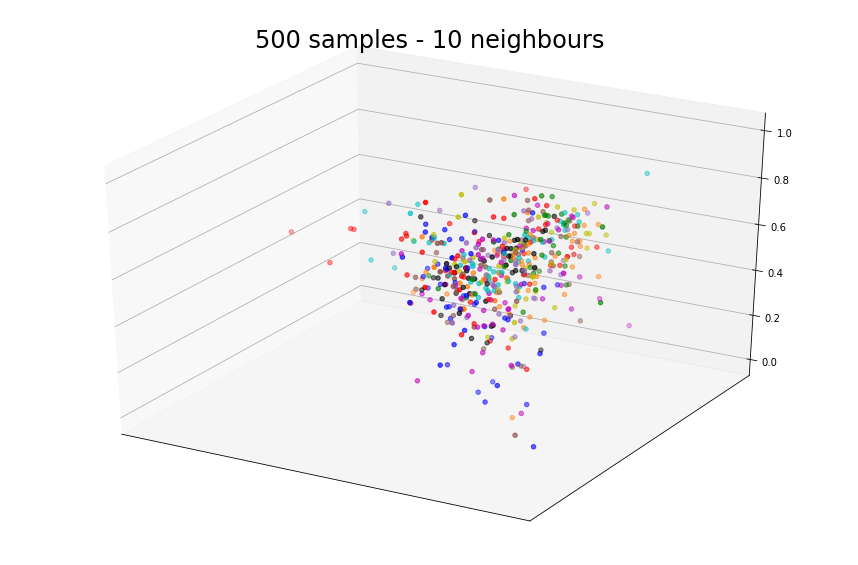

In [249]:
nb_neighb=10
Y, M_skW, W_skW = sk_lle(X, nb_neighb, out_d=3, metric=sklearn.metrics.mutual_info_score)
plot_embedding(Y, y, "{} samples - {} neighbours".format(
            X.shape[0], nb_neighb))

## Interpolating in the original space

In [77]:
img1 = X[0].reshape((28,28))
img2 = X[1].reshape((28,28))
l = 0.5
img3 = img1 * l + img2 * (1-l)

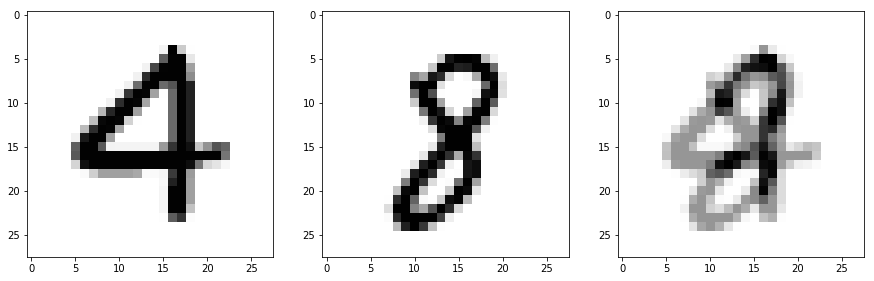

In [172]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(img1, cmap="Greys")
plt.subplot(1,3,2)
plt.imshow(img2, cmap="Greys")
plt.subplot(1,3,3)
plt.imshow(img3, cmap="Greys")

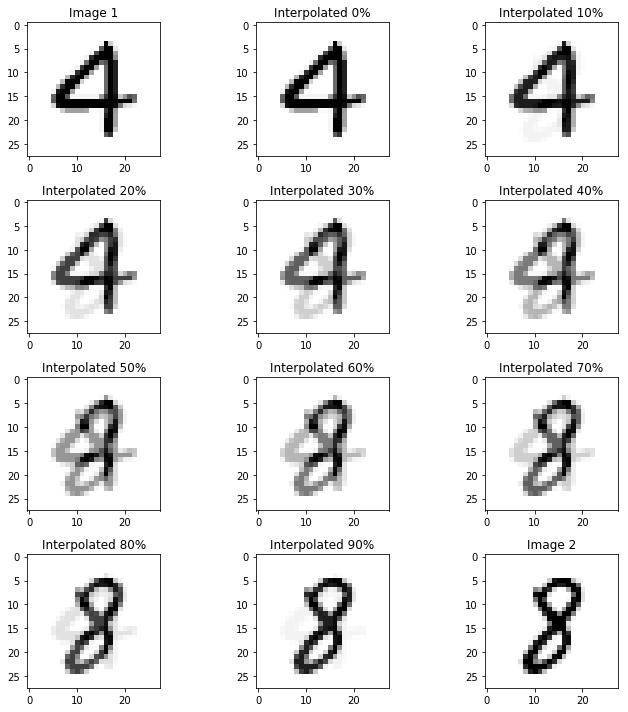

In [243]:
fig = plt.figure(figsize=(10,10))
plt.subplot(4,3,1)
plt.imshow(X[0].reshape((28,28)), cmap="Greys")
plt.title("Image 1")

for i in range(11):
    l = i/10.
    X_int = X[0] * (1-l) + X[1] * l
    
    plt.subplot(4,3,2+i)
    plt.imshow(X_int.reshape((28,28)), cmap="Greys")
    plt.title("Interpolated " + str(i*10) + "%")

plt.subplot(4,3,12)
plt.imshow(X[1].reshape((28,28)), cmap="Greys")
plt.title("Image 2")

plt.tight_layout()

## Interpolating in the embedding space

In [159]:
Y_int = Y[0,0:] * l + Y[1,0:] * (1-l)
Y_int.shape

(3,)

In [157]:
NearestNeighbors(1).fit(Y).kneighbors(Y_int)

/home/lucio/anaconda3/envs/Python3.6_latest_versions/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(array([[ 0.00247576]]), array([[697]]))

In [184]:
Y_base_int_pos = W_skW[697,].nonzero()[0][:len(Y_int)]
Y_base_int = Y[Y_base_int_pos]

In [193]:
Y_base_int_pos

array([ 67, 220, 249])

In [200]:
W_int = scipy.linalg.solve(Y_base_int, Y_int)
W_int = W_int / np.sum(W_int)

In [201]:
X_int = W_int@X[Y_base_int_pos]

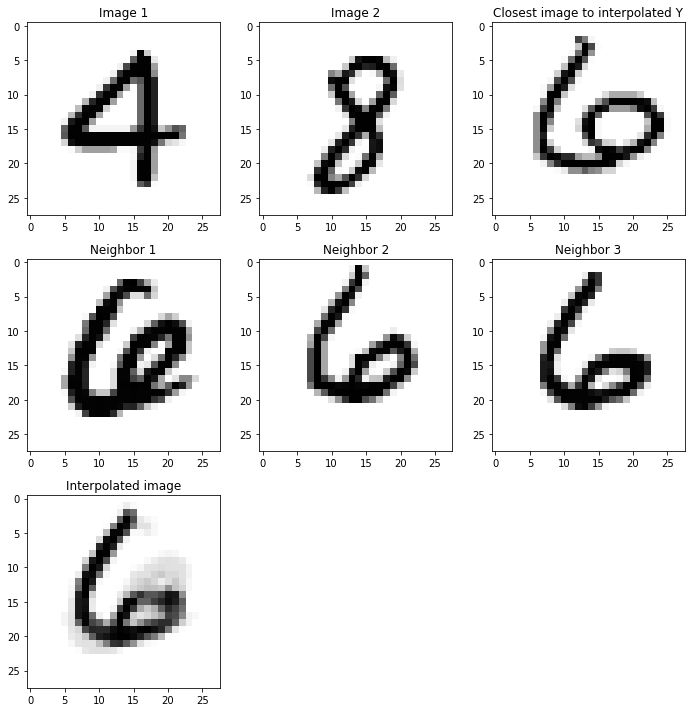

In [227]:
fig = plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
plt.imshow(X[0].reshape((28,28)), cmap="Greys")
plt.title("Image 1")
plt.subplot(3,3,2)
plt.imshow(X[1].reshape((28,28)), cmap="Greys")
plt.title("Image 2")
plt.subplot(3,3,3)
plt.imshow(X[697].reshape((28,28)), cmap="Greys")
plt.title("Closest image to interpolated Y")
plt.subplot(3,3,4)
plt.imshow(X[Y_base_int_pos[0]].reshape((28,28)), cmap="Greys")
plt.title("Neighbor 1")
plt.subplot(3,3,5)
plt.imshow(X[Y_base_int_pos[1]].reshape((28,28)), cmap="Greys")
plt.title("Neighbor 2")
plt.subplot(3,3,6)
plt.imshow(X[Y_base_int_pos[2]].reshape((28,28)), cmap="Greys")
plt.title("Neighbor 3")
plt.subplot(3,3,7)
plt.imshow(X_int.reshape((28,28)), cmap="Greys")
plt.title("Interpolated image")
plt.tight_layout()

## Interpolating in the embedding space - full convex combination

In [228]:
Y_int = Y[0,0:] * l + Y[1,0:] * (1-l)
_, neig = NearestNeighbors(1).fit(Y).kneighbors(Y_int)
neig[0][0]

/home/lucio/anaconda3/envs/Python3.6_latest_versions/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


/home/lucio/anaconda3/envs/Python3.6_latest_versions/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/lucio/anaconda3/envs/Python3.6_latest_versions/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/lucio/anaconda3/envs/Python3.6_latest_versions/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.resh

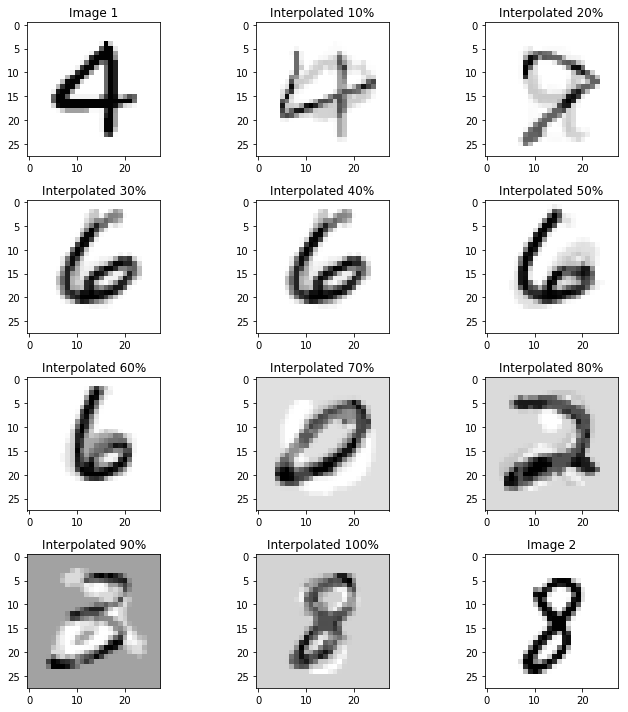

In [244]:
fig = plt.figure(figsize=(10,10))
plt.subplot(4,3,1)
plt.imshow(X[0].reshape((28,28)), cmap="Greys")
plt.title("Image 1")

for i in range(1,11):
    l = i/10.
    Y_int = Y[0,0:] * (1-l) + Y[1,0:] * l
    _, neig = NearestNeighbors(1).fit(Y).kneighbors(Y_int)
    X_closest = X[neig[0][0]]
    Y_base_int_pos = W_skW[neig[0][0],].nonzero()[0][:len(Y_int)]
    Y_base_int = Y[Y_base_int_pos]
    W_int = scipy.linalg.solve(Y_base_int, Y_int)
    W_int = W_int / np.sum(W_int)
    X_int = W_int@X[Y_base_int_pos]
    
    plt.subplot(4,3,1+i)
    plt.imshow(X_int.reshape((28,28)), cmap="Greys")
    plt.title("Interpolated " + str(i*10) + "%")

plt.subplot(4,3,12)
plt.imshow(X[1].reshape((28,28)), cmap="Greys")
plt.title("Image 2")

plt.tight_layout()

## Approximation in the embedding space - full convex combination

/home/lucio/anaconda3/envs/Python3.6_latest_versions/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/lucio/anaconda3/envs/Python3.6_latest_versions/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/lucio/anaconda3/envs/Python3.6_latest_versions/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.resh

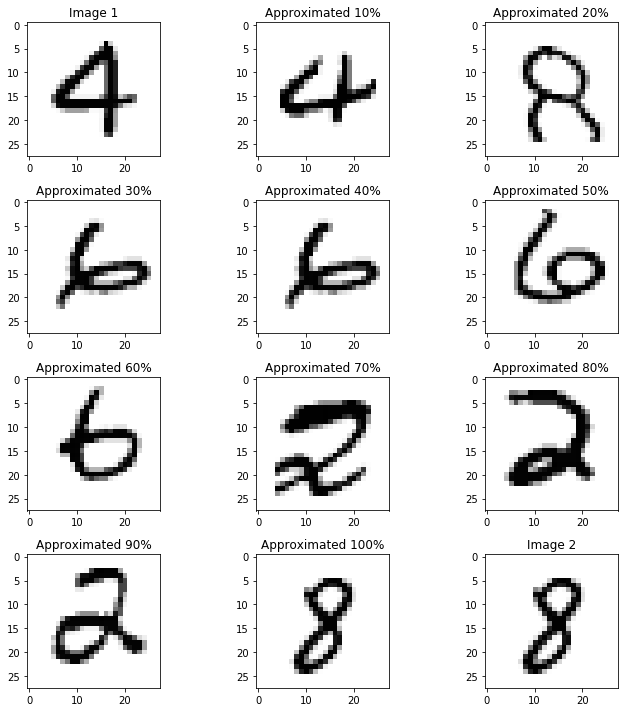

In [246]:
fig = plt.figure(figsize=(10,10))
plt.subplot(4,3,1)
plt.imshow(X[0].reshape((28,28)), cmap="Greys")
plt.title("Image 1")

for i in range(1,11):
    l = i/10.
    Y_int = Y[0,0:] * (1-l) + Y[1,0:] * l
    _, neig = NearestNeighbors(1).fit(Y).kneighbors(Y_int)
    X_closest = X[neig[0][0]]
    Y_base_int_pos = W_skW[neig[0][0],].nonzero()[0][:len(Y_int)]
    Y_base_int = Y[Y_base_int_pos]
    W_int = scipy.linalg.solve(Y_base_int, Y_int)
    W_int = W_int / np.sum(W_int)
    X_int = W_int@X[Y_base_int_pos]
    
    plt.subplot(4,3,1+i)
    plt.imshow(X_closest.reshape((28,28)), cmap="Greys")
    plt.title("Approximated " + str(i*10) + "%")

plt.subplot(4,3,12)
plt.imshow(X[1].reshape((28,28)), cmap="Greys")
plt.title("Image 2")

plt.tight_layout()